In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

from skimage import feature
#from skued.image import powder_center
from matplotlib.patches import Rectangle, Circle

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel.dm4'
datacube = py4DSTEM.file.io.read(filename)
#filename = 'Diffraction of vacuum_256x256_50_25.dm3'
#vacuum_data = py4DSTEM.file.io.read(filename)

Bin(2,2,2, 2) of outer enamel.dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
filename = 'Diffraction of vacuum_256x256_50_25.dm3'
from ncempy.io import dm
vacuum = dm.dmReader(filename)

In [4]:
# Setting scan shapes(need the experimental scan dimensions)
datacube.set_scan_shape(133,131)
datacube.name = 'datacube'
#vacuum_data.set_scan_shape(4,16)
#vacuum_data.name = 'vacuum'

In [5]:
#normalize datacube by vacuum probe (Paul & Roberto, please let me know if this is correct)
vacuum_sum=np.sum(vacuum['data'])
normalized_data=datacube.data/vacuum_sum

<IPython.core.display.Javascript object>


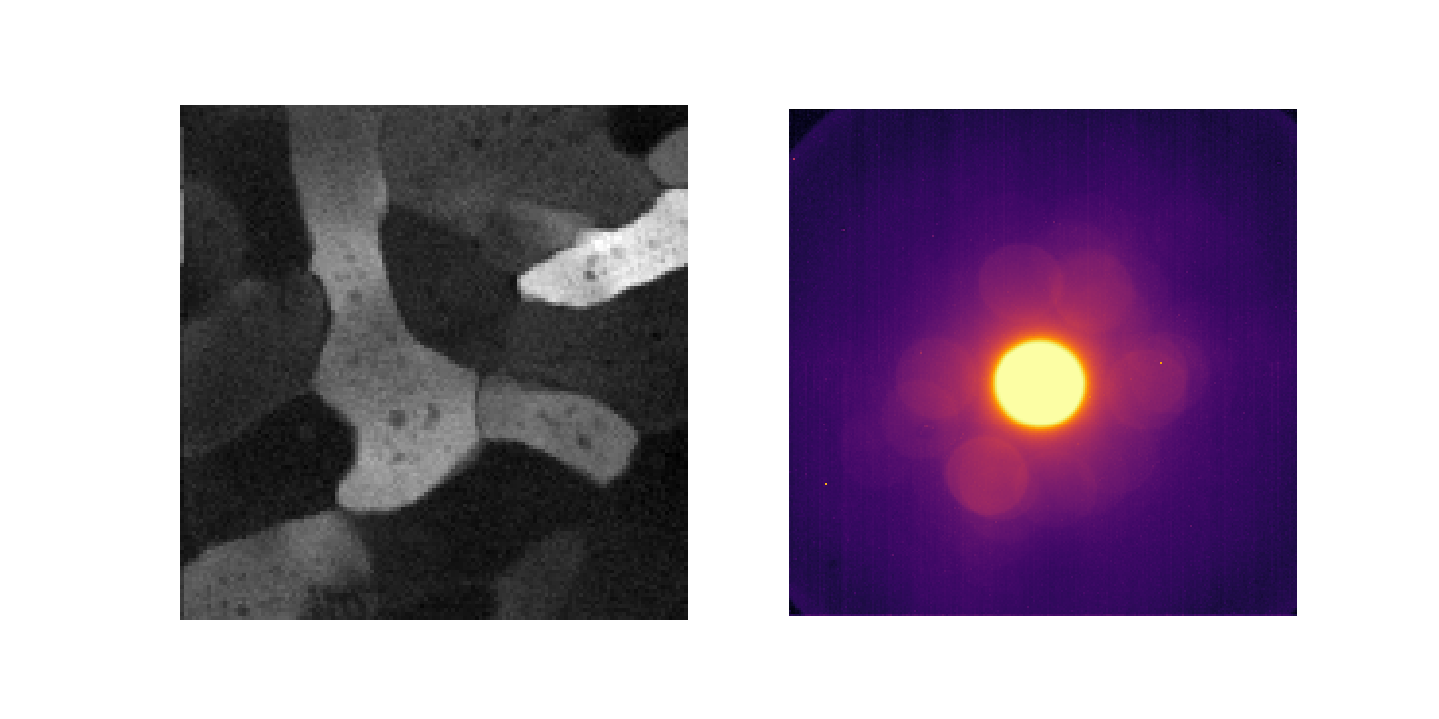

In [6]:
aveDP = np.average(normalized_data, axis=(0,1))
realimage=np.average(normalized_data, axis=(2,3))

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(realimage)
ax[1].matshow(np.sqrt(aveDP), cmap=plt.cm.inferno)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [7]:
#find center points of mask
blob=feature.blob_log(aveDP, threshold = .0001)
ic=blob[0,0]
jc=blob[0,1]

<IPython.core.display.Javascript object>


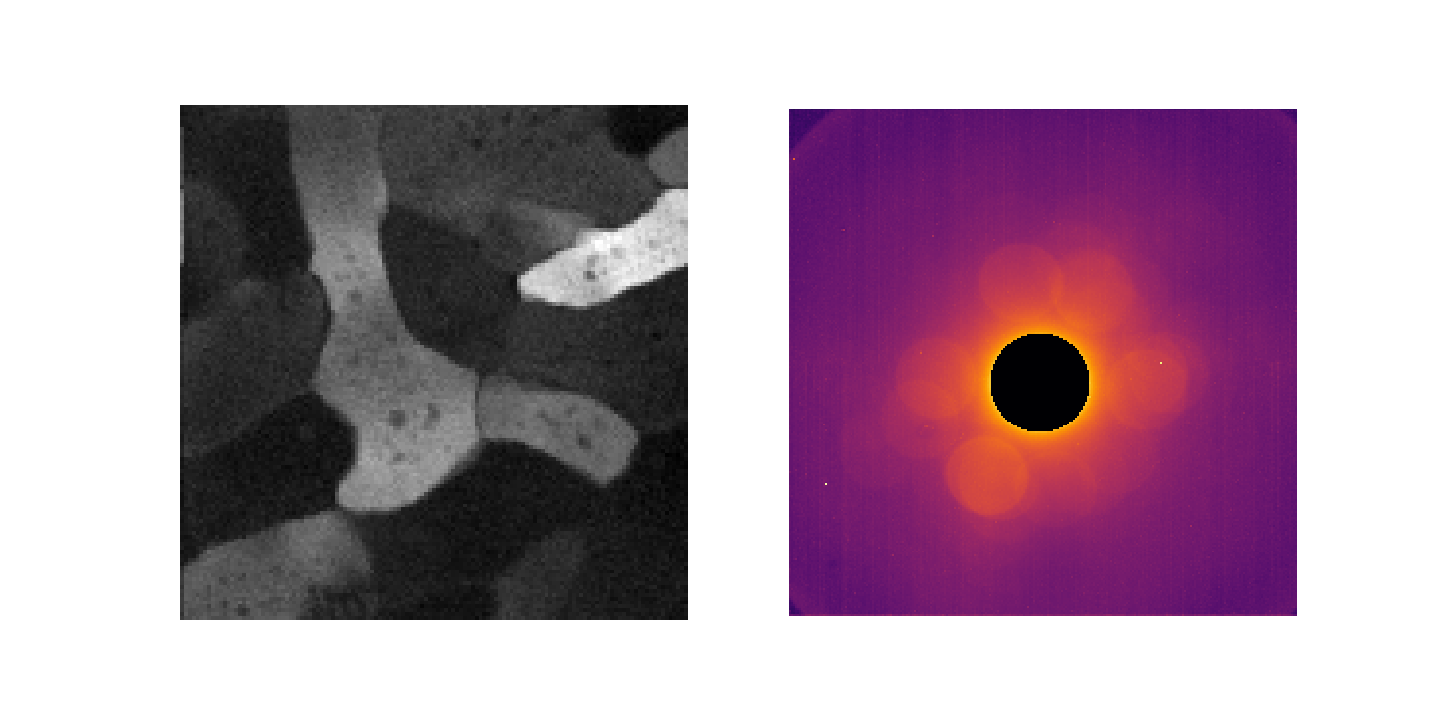

In [8]:
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 25 ** 2

masked_data=normalized_data

for i in range(0,aveDP.shape[0]):
    for j in  range(0,aveDP.shape[1]):
        if mask_circle[i,j]: 
            masked_data[:,:,i,j]=0

aveDP_masked = np.average(masked_data, axis=(0,1))

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(realimage)
ax[1].matshow(np.sqrt(aveDP_masked), cmap=plt.cm.inferno)
ax[0].axis('off')
ax[1].axis('off')
plt.show()
        

<IPython.core.display.Javascript object>


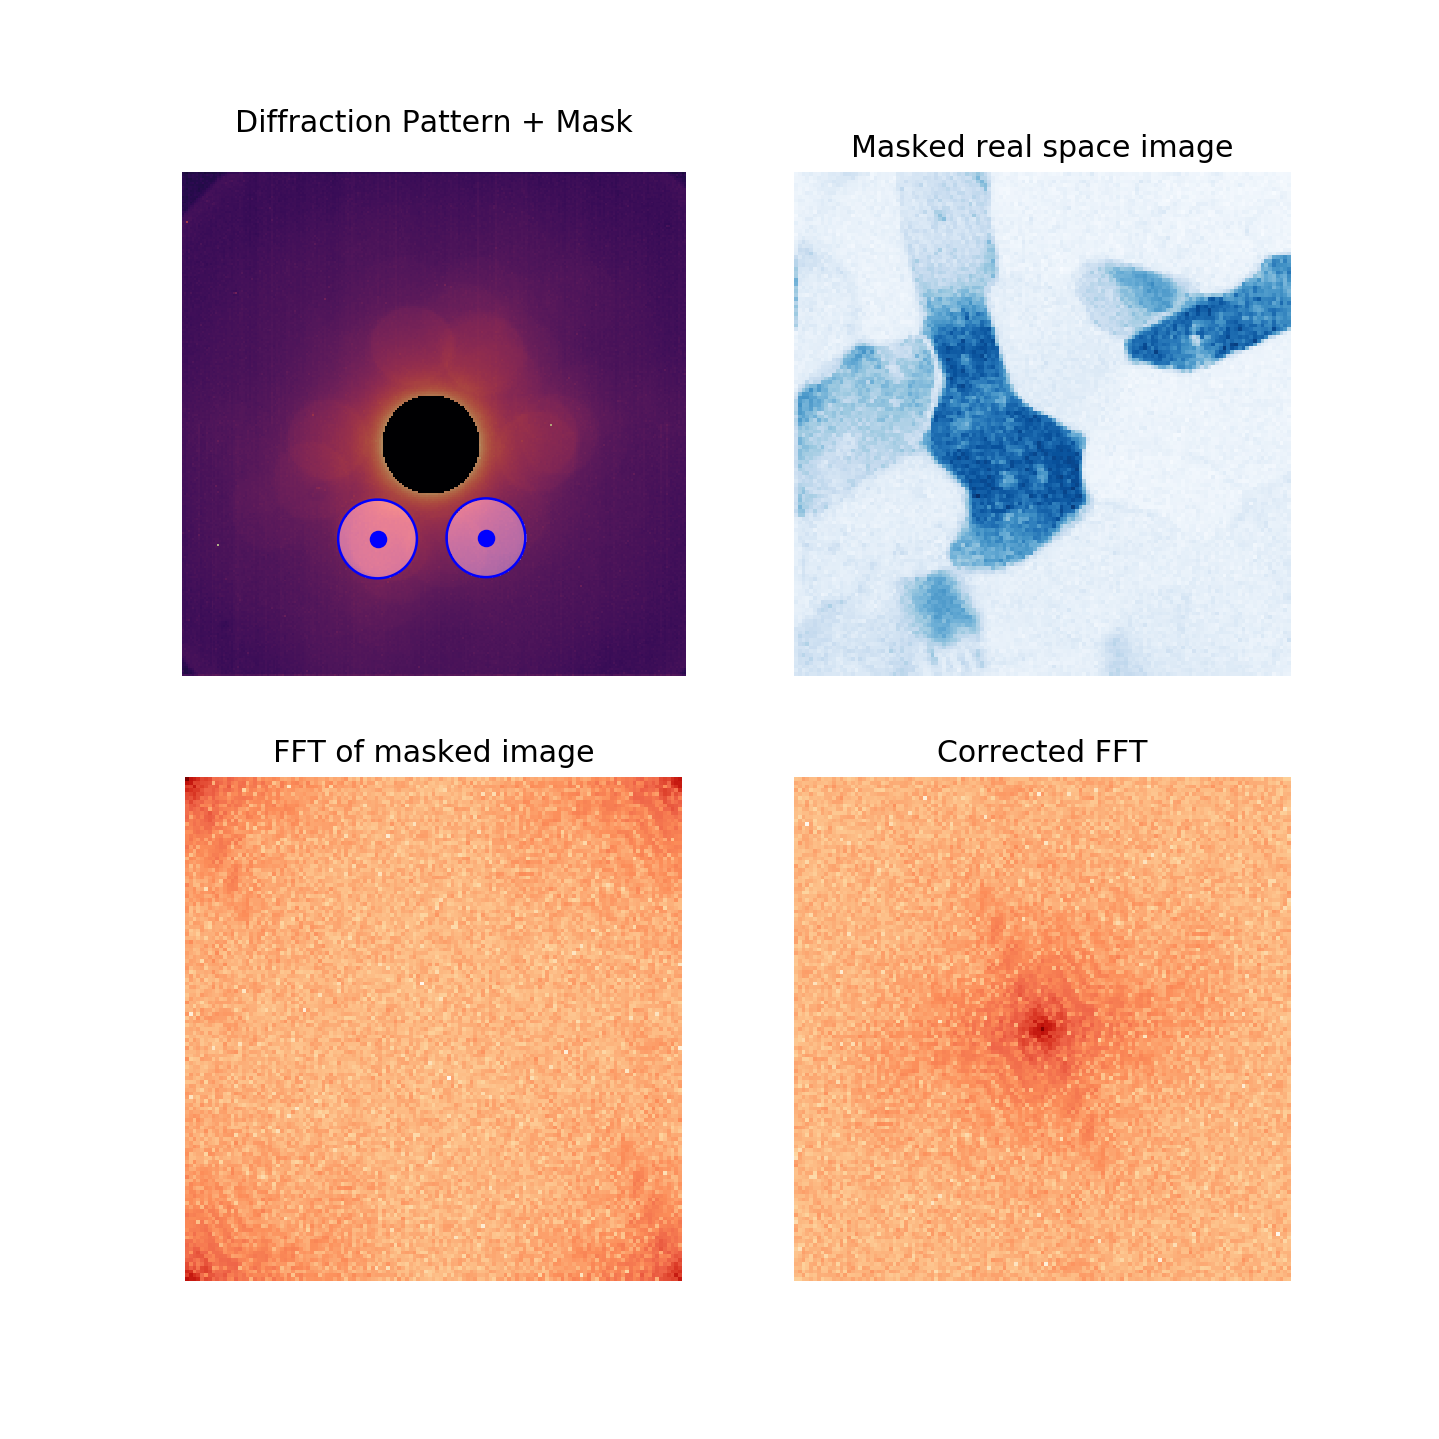

In [9]:
#masked FFT
x1,y1 = 99,186

theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[x1-jc],[y1-ic]])
v=np.dot(v.T,R).T

x2=v[0,0]+jc
y2=v[1,0]+ic

#make mask
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle1 = (y - x1) ** 2 + (x - y1) ** 2 < 20 ** 2
mask_circle2 = (y - x2) ** 2 + (x - y2) ** 2 < 20 ** 2
combine_mask = np.logical_or(mask_circle1, mask_circle2)

#extract data in map 
two_spots=np.zeros((normalized_data.shape[0],normalized_data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
        if combine_mask[i,j]: 
            two_spots=two_spots+masked_data[:,:,i,j] 

                        
#take fft
fft_two_spots_raw=np.fft.fft2(two_spots)
fft_image_raw_shifted = np.fft.fftshift(fft_two_spots_raw)


#plot
fig,ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].matshow(np.sqrt(aveDP_masked), cmap = plt.cm.magma)
ax[0,0].scatter(x1, y1, color='b')
ax[0,0].scatter(x2, y2, color='b')

circ = Circle((x1,y1),20,fill=False,color='b')
ax[0,0].add_patch(circ)

circ = Circle((x2,y2),20,fill=False,color='b')
ax[0,0].add_patch(circ)

#plot mask to check it aligns 
ax[0,0].imshow(combine_mask, alpha=0.3)

ax[0,1].imshow(two_spots, cmap=plt.cm.Blues)


im_handle = ax[1,0].imshow(np.log10(np.abs(fft_two_spots_raw)), cmap=plt.cm.OrRd)
#cbar = plt.colorbar(im_handle, ax=ax[0], fraction=0.046, pad=0.04)

im_handle = ax[1,1].imshow(np.log10(np.abs(fft_image_raw_shifted)), cmap=plt.cm.OrRd)
#cbar = plt.colorbar(im_handle, ax=ax[1], fraction=0.046, pad=0.04)


ax[0,0].set_title('Diffraction Pattern + Mask')
ax[0,1].set_title('Masked real space image')
ax[1,0].set_title('FFT of masked image')
ax[1,1].set_title('Corrected FFT')

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

plt.show()

<IPython.core.display.Javascript object>


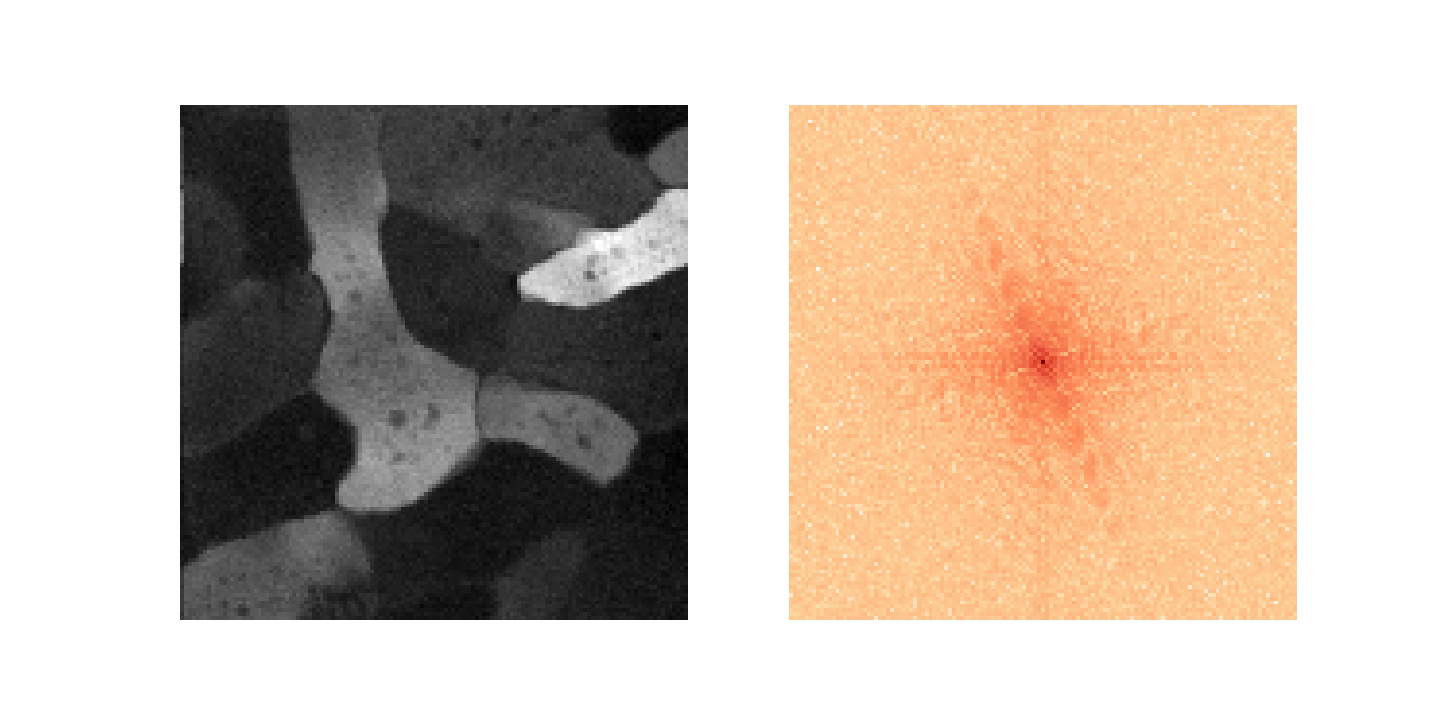

In [10]:
#FFT of unmasked real space image
fft_real_raw=np.fft.fft2(realimage)
fft_real_shifted = np.fft.fftshift(fft_real_raw)

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(realimage)
#ax[0].imshow(np.log10(np.abs(fft_image_raw_shifted)), cmap=plt.cm.OrRd)
ax[1].matshow(np.log10(np.abs(fft_real_shifted)), cmap=plt.cm.OrRd)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

<IPython.core.display.Javascript object>


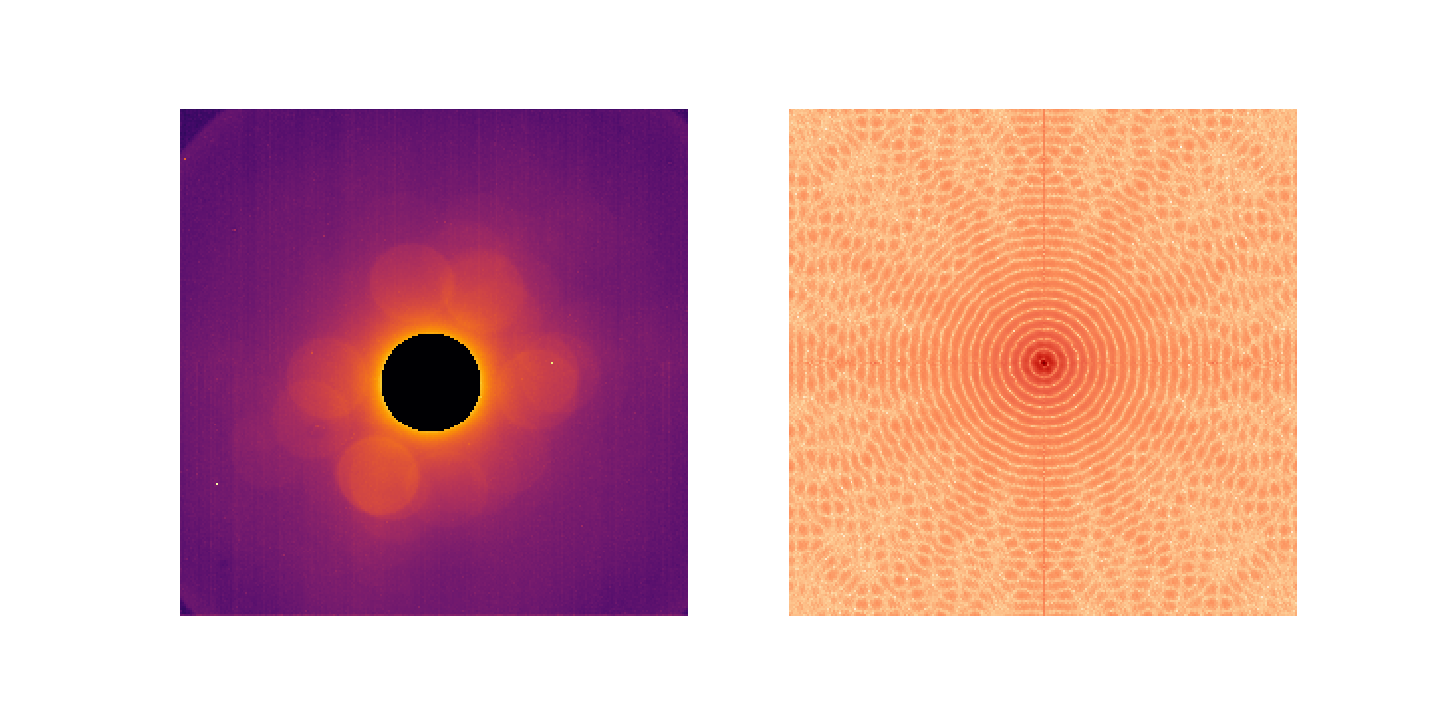

In [11]:
#FFT of average diffraction pattern
fft_DP_raw=np.fft.fft2(aveDP_masked)
fft_DP_shifted = np.fft.fftshift(fft_DP_raw)

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(np.sqrt(aveDP_masked), cmap=plt.cm.inferno)
ax[1].matshow(np.log10(np.abs(fft_DP_shifted)), cmap=plt.cm.OrRd)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

<IPython.core.display.Javascript object>


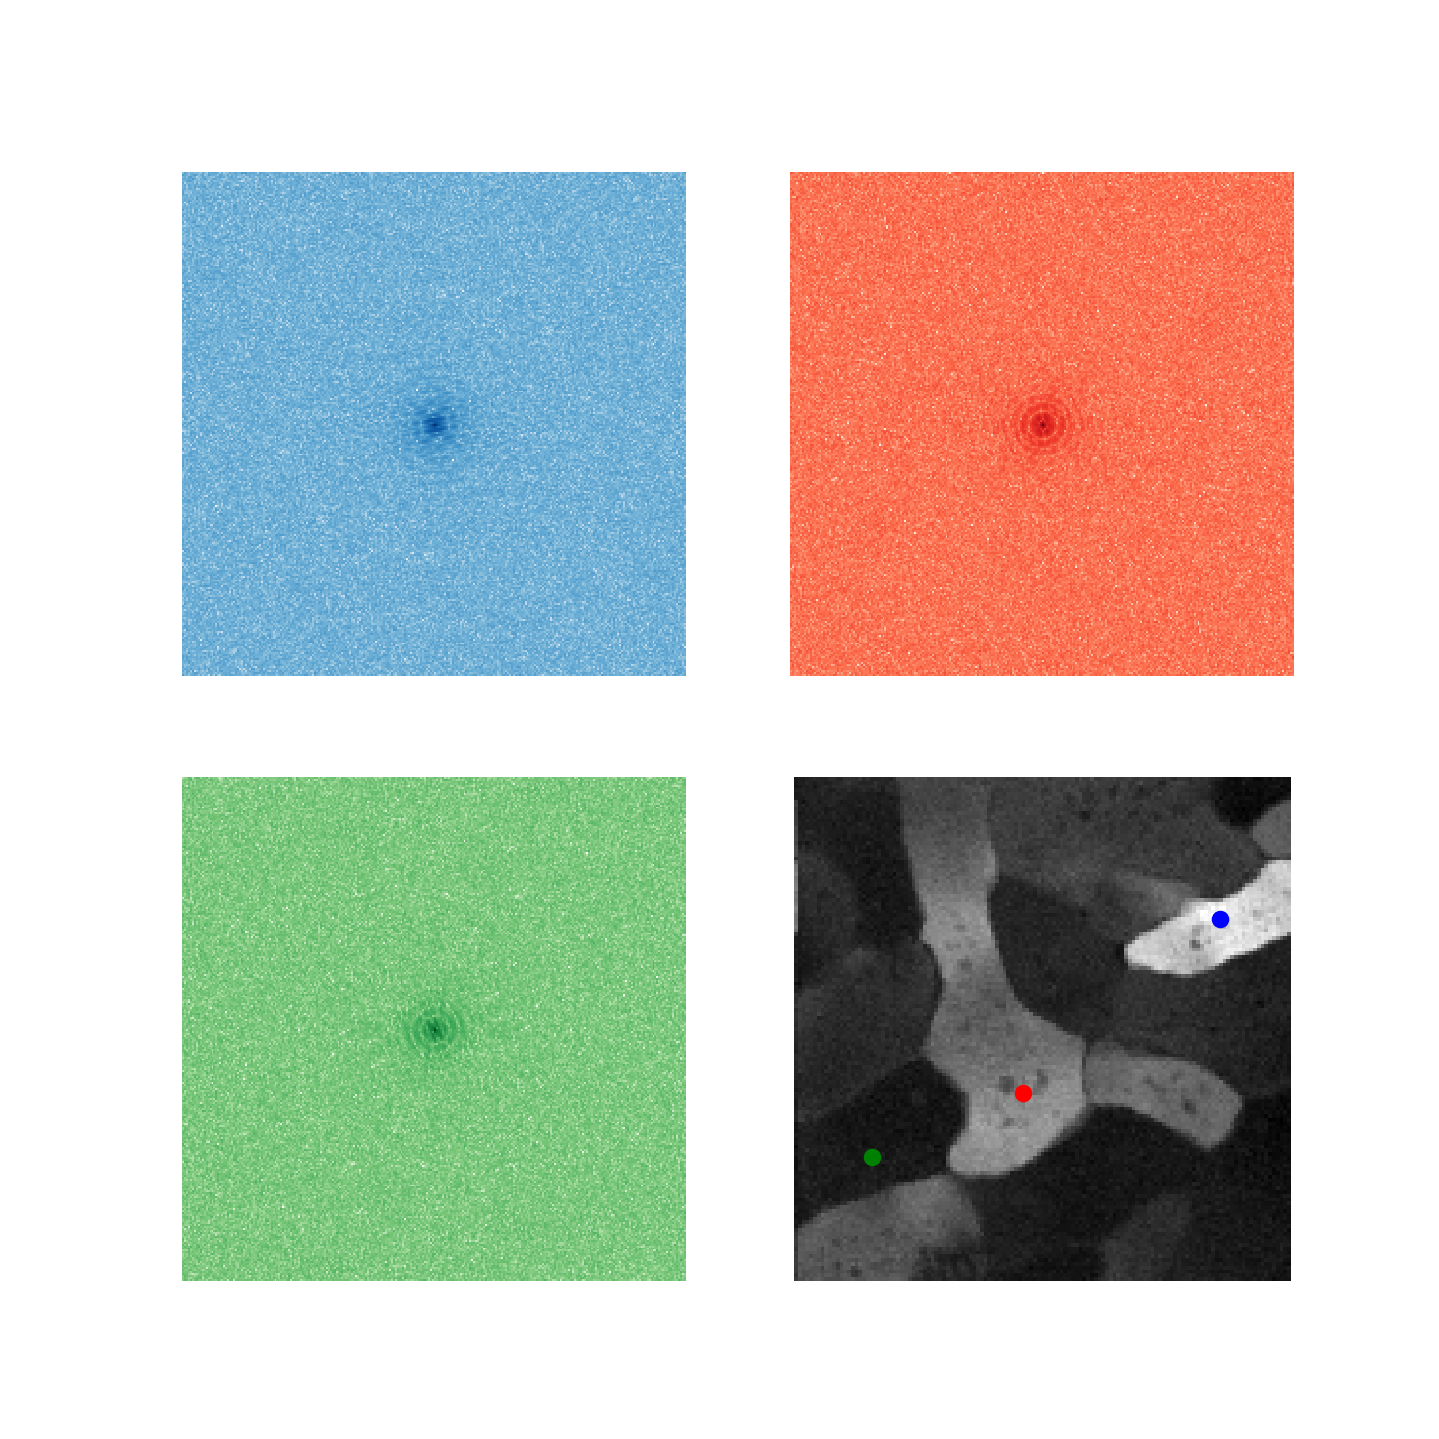

In [12]:
#FFT of individual diffraction pattern
xa,ya = 112,37
xb,yb = 60, 83
xc,yc = 20, 100

fft_DP_raw_1=np.fft.fft2(masked_data[xa,ya,:,:])
fft_DP_shifted_1 = np.fft.fftshift(fft_DP_raw_1)

fft_DP_raw_2=np.fft.fft2(masked_data[xb,yb,:,:])
fft_DP_shifted_2 = np.fft.fftshift(fft_DP_raw_2)

fft_DP_raw_3=np.fft.fft2(masked_data[xc,yc,:,:])
fft_DP_shifted_3 = np.fft.fftshift(fft_DP_raw_3)


fig,ax=plt.subplots(2,2,figsize=(8,8))
ax[0,0].matshow(np.log10(np.abs(fft_DP_shifted_1)), cmap=plt.cm.Blues)
ax[0,1].matshow(np.log10(np.abs(fft_DP_shifted_2)), cmap=plt.cm.Reds)
ax[1,0].matshow(np.log10(np.abs(fft_DP_shifted_3)), cmap=plt.cm.Greens)
ax[1,1].matshow(realimage)

ax[1,1].scatter(xa,ya, color="blue")
ax[1,1].scatter(xb,yb, color="red")
ax[1,1].scatter(xc,yc, color="green")

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
plt.show()

<IPython.core.display.Javascript object>


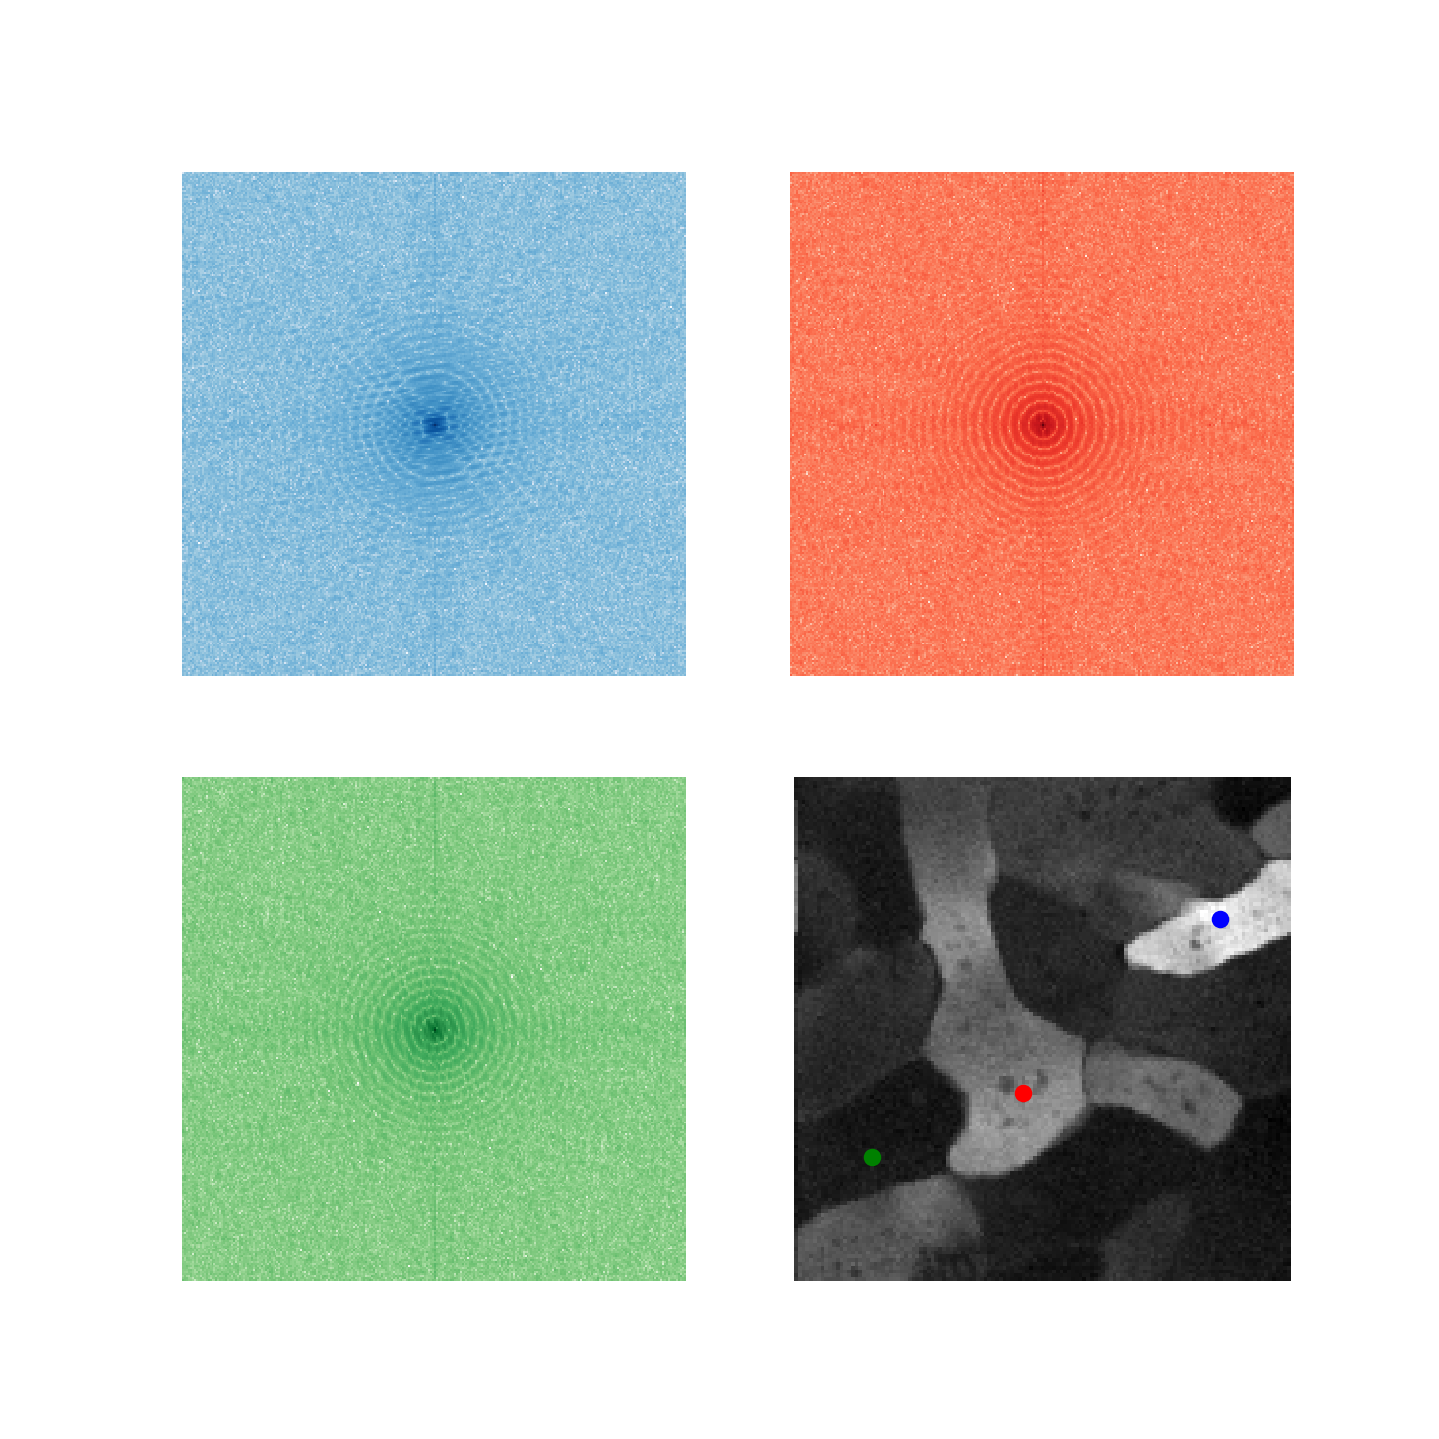

In [13]:
#FFT of individual diffraction pattern
xa,ya = 112,37
xb,yb = 60, 83
xc,yc = 20, 100

fft_DP_raw_1=np.fft.fft2(np.average(masked_data[xa-3:xa+3,ya-3:ya+3,:,:], axis=(0,1)))
fft_DP_shifted_1 = np.fft.fftshift(fft_DP_raw_1)

fft_DP_raw_2=np.fft.fft2(np.average(masked_data[xb-3:xb+3,yb-3:yb+3,:,:], axis=(0,1)))
fft_DP_shifted_2 = np.fft.fftshift(fft_DP_raw_2)

fft_DP_raw_3=np.fft.fft2(np.average(masked_data[xc-3:xc+3,yc-3:yc+3,:,:], axis=(0,1)))
fft_DP_shifted_3 = np.fft.fftshift(fft_DP_raw_3)


fig,ax=plt.subplots(2,2,figsize=(8,8))
ax[0,0].matshow(np.log10(np.abs(fft_DP_shifted_1)), cmap=plt.cm.Blues)
ax[0,1].matshow(np.log10(np.abs(fft_DP_shifted_2)), cmap=plt.cm.Reds)
ax[1,0].matshow(np.log10(np.abs(fft_DP_shifted_3)), cmap=plt.cm.Greens)
ax[1,1].matshow(realimage)

ax[1,1].scatter(xa,ya, color="blue")
ax[1,1].scatter(xb,yb, color="red")
ax[1,1].scatter(xc,yc, color="green")

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
plt.show()

In [14]:
#mask center disk and take fft